In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from scipy.ndimage import generic_filter, gaussian_filter, median_filter
from skimage.morphology import erosion, disk
import marker_detection

%matplotlib inline
# Étend la taille des figures
plt.rcParams["figure.figsize"] = (12, 7)

In [6]:
image = cv2.imread(r'C:\Users\LEA\Desktop\Poly\H2023\Projet3\Data\Ete_2022\Participant05\autocorrection\Prise01\intensity\auto_01_010457_I_0.jpg')
crop = (350, 1500, 200, 1000)

image = marker_detection.preprocess(image, crop)[0]

plt.imshow(image, cmap='gray')
plt.show()

TypeError: 'NoneType' object is not subscriptable

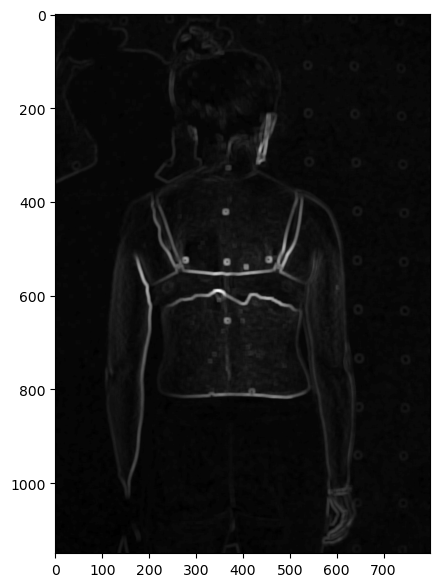

In [102]:
w = image.shape[0]
h = image.shape[1]
im_std = generic_filter(image, np.std, 9, mode='nearest').reshape(w,h)
plt.imshow(im_std, cmap='gray')
plt.show()

4.0141989130434785 80
81
522 433


C:\Users\LEA\AppData\Local\Temp\ipykernel_14116\3271735743.py:17: UserWarning: Attempting to set identical bottom == top == -0.5 results in singular transformations; automatically expanding.
  ax3.imshow(image2, cmap='gray')


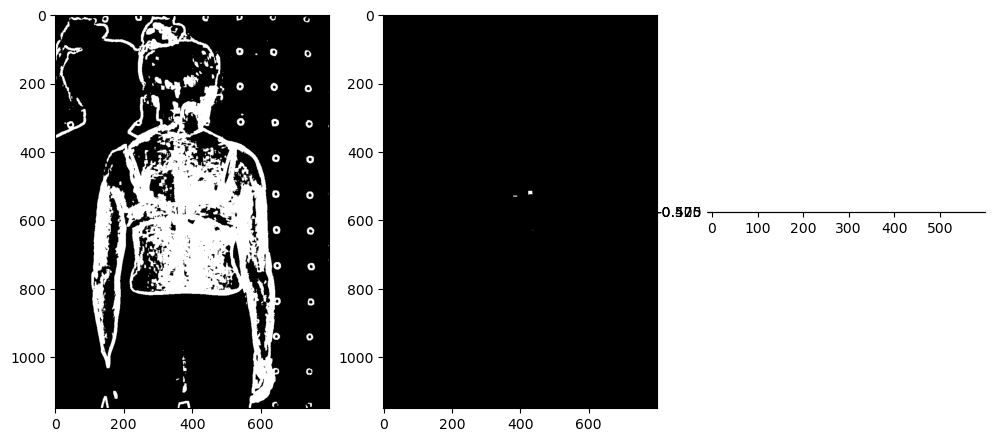

In [103]:
mean = im_std.mean()
max = im_std.max()
print(mean, max)
im_crop = np.where(im_std > mean, 1, 0)
im_crop_g = gaussian_filter(im_crop, 7)
crop = np.where(im_crop_g == 1)
mid = int(len(crop[0])/2)
print(mid)
crop_y = crop[0][mid]
crop_x = crop[1][mid]
print(crop_y, crop_x)

image2 = image[crop_y-800:crop_y+80, crop_x-350:crop_x+250]
fig, (ax1, ax2, ax3) = plt.subplots(1,3)
ax1.imshow(im_crop, cmap='gray')
ax2.imshow(im_crop_g, cmap='gray')
ax3.imshow(image2, cmap='gray')
plt.show()

(1935, 1176, 3)
0 255 42.38468992248062


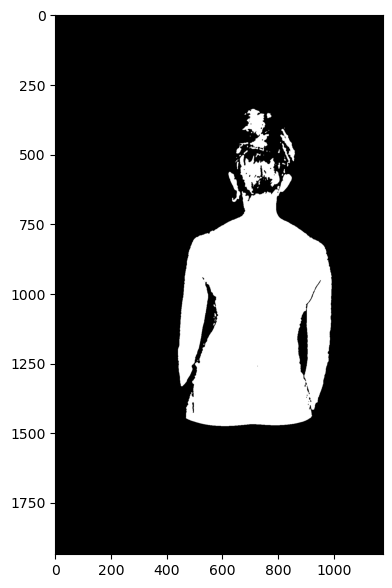

In [11]:
z_nobg = cv2.imread(r'D:\StageE23\Data\Hiver_2022\14-03-2022_Participant1\Prise1\xyz_nobg\Prise1_005943_XYZ_0.png')
print(z_nobg.shape)
print(np.min(z_nobg), np.max(z_nobg), np.mean(z_nobg))

plt.imshow(z_nobg)
plt.show()

(3, 3)


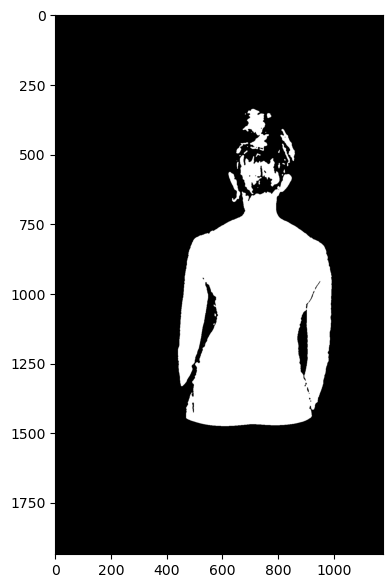

[[ 337  707]
 [ 337  708]
 [ 337  709]
 ...
 [1475  621]
 [1475  622]
 [1475  623]]


In [12]:
footprint = disk(1, np.uint16)
print(footprint.shape)
z_nobg = median_filter(z_nobg, 5)
plt.imshow(z_nobg)
plt.show()

body = np.argwhere(z_nobg[:1500,:,0] > 100)
print(body)

[337 707] [1199  441] [983 991]


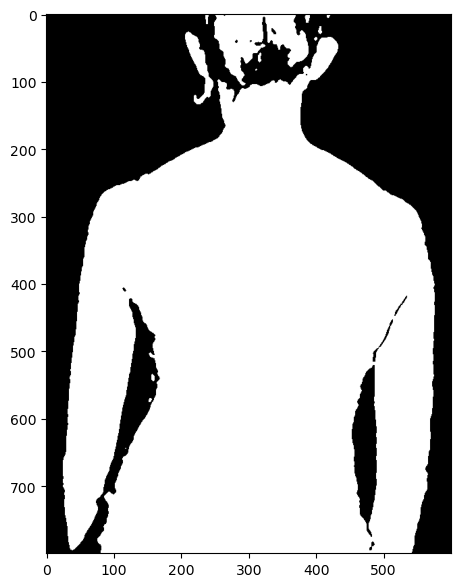

In [16]:
top = body[0]
body_sorted = sorted(body, key=lambda list: list[1])
left = body_sorted[0]
right = body_sorted[-1]
print(top, left, right)

w1 = left[1]-25
w2 = right[1]+25
h1 = top[0]+200
h2 = top[0]+1000

im_crop = z_nobg[h1:h2, w1:w2, :]
plt.imshow(im_crop)
plt.show()